# 👋 Hướng dẫn tích hợp submodular

Trong hướng dẫn này, chúng ta sẽ tìm hiểu cách phương pháp tối ưu hóa submodular hoạt động trên nền tảng ViT (Vision Transformer) với mô hình ViT-L/14.

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.chdir("../")

import sys
sys.path.insert(1, "/home/pinats/submodular/")

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import clip

plt.style.use('seaborn-v0_8')

from utils import *
import matplotlib

matplotlib.get_cachedir()
# plt.rc('font', family="Times New Roman")
from sklearn import metrics

import torch
from torchvision import transforms

In [25]:
def imshow(img):
    """
    Hiển thị hình ảnh trong Jupyter Notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# đảo ngược kênh màu của ảnh
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

### 🛠️ Thiết lập mô hình và hàm tiền xử lý

Vì các mô hình đa phương thức (multi-modal), như **CLIP**, có đầu vào dạng luồng kép (dual-stream input), chúng ta cần bộ mã hóa hình ảnh của nó. Đầu vào là một ảnh có dạng `[B, C, W, H]` trong định dạng **torch**, và đầu ra là một vector d-dimensional có dạng `[B, d]`. Vì vậy, hãy chuyển đổi mô hình.

In [26]:
class CLIPModel_Super(torch.nn.Module):
    def __init__(self, 
                 type="ViT-L/14",
                 download_root=None,
                 device = "cuda"):
        super().__init__()
        self.device = device
        self.model, _ = clip.load(type, device=self.device, download_root=download_root)
        
    def forward(self, vision_inputs):
        """
        Input:
            vision_inputs: torch.size([B,C,W,H])
        Output:
            embeddings: a d-dimensional vector torch.size([B,d])
        """
        with torch.no_grad():
            image_features = self.model.encode_image(vision_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        return image_features

Chuẩn bị một hàm tiền xử lý, đầu vào là một hình ảnh có định dạng đọc bởi `OpenCV` (định dạng kênh màu là BGR), và đầu ra là Tensor đã được tiền xử lý, như sau:

In [27]:
data_transform = transforms.Compose(
    [
        transforms.Resize(
            (224,224), interpolation=transforms.InterpolationMode.BICUBIC
        ),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# Hàm chuyển đổi dữ liệu thành tensor 
def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image = data_transform(image)
    return image

Đọc ảnh

In [28]:
# Sửa đường dẫn của ảnh như theo đường dẫn trên máy tính
image_path = "/home/pinats/submodular/ImageBind/.assets/dog_image.jpg"

In [29]:
image = cv2.imread(image_path)
image = transform_vision_data(image)
print(image.shape)

torch.Size([3, 224, 224])


In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Instantiate model
vis_model = CLIPModel_Super("ViT-L/14", download_root="/home/pinats/submodular/.checkpoints/CLIP")
vis_model.eval() #Chuyển chế độ đánh giá
vis_model.to(device)
print("load clip model ViT-L/14")

load clip model ViT-L/14


In [31]:
vis_feature = vis_model(image.unsqueeze(0).to(device))
print("The output size of the visual feature is {}.".format(vis_feature.shape))

The output size of the visual feature is torch.Size([1, 768]).


### ✏️ Phân chia tiểu vùng

Sử dụng phương pháp SLICO để thực hiện phân chia tiểu vùng.

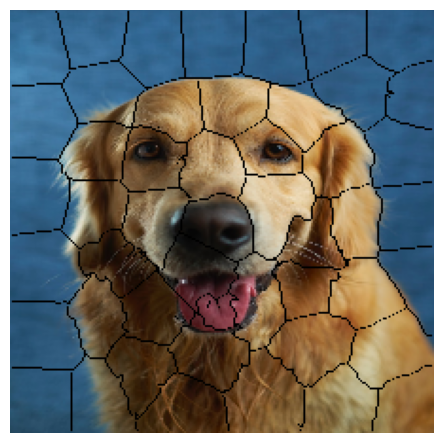

In [32]:
img = cv2.imread(image_path)
img = cv2.resize(img, (224,224))
slic = cv2.ximgproc.createSuperpixelSLIC(img, region_size=30, ruler = 20.0) 
slic.iterate(20)     #Số lần lặp càng lớn, hiệu quả càng cao.
mask_slic = slic.getLabelContourMask() #Lấy Mask, trong đó các cạnh của siêu pixel (superpixel edges) có giá trị Mask == 1.
label_slic = slic.getLabels()        #Lấy nhãn siêu pixel.
number_slic = slic.getNumberOfSuperpixels()  #Lấy số lượng siêu pixel.
mask_inv_slic = cv2.bitwise_not(mask_slic)
img_slic = cv2.bitwise_and(img, img, mask =  mask_inv_slic) #Vẽ đường biên siêu pixel lên ảnh gốc.

imshow(img_slic)

Đơn giản hóa quá trình theo các dưới

In [33]:
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
element_sets_V = SubRegionDivision(image, mode="slico")

In [34]:
# Import class tính toán submodular
from models.submodular_vit_torch import MultiModalSubModularExplanation

In [35]:
text_list=[
    "A dog.", "A car.", "A bird.", "An airplane.", "A bicycle.", 
    "A boat.", "A cat.", "A chair", "A cow.", "A diningtable.", 
    "A horse.", "A motorbike.", "A person.", "A pottedplant.", "A sheep.", 
    "A sofa.", "A train.", "A tvmonitor."]
text_modal_input = clip.tokenize(text_list).to(device)

with torch.no_grad():
    semantic_feature = vis_model.model.encode_text(text_modal_input) * 100

explainer = MultiModalSubModularExplanation(
    vis_model, semantic_feature, transform_vision_data, device=device, lambda1 = 0, lambda2 = 0.05, lambda3 = 1, lambda4=1)

In [ ]:
explainer.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = explainer(element_sets_V, id=0)

  0%|                                                                                            | 0/49 [00:00<?, ?it/s]

### 😮 Trực quan hóa

In [17]:
def visualization(image, submodular_image_set, saved_json_file, index=None):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[1:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array(saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [(insertion_ours_image.sum(-1)!=0).sum() / (image.shape[0] * image.shape[1]) for insertion_ours_image in insertion_ours_images]
    i = len(x)

    fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    plt.title('Insertion', fontsize=54)
    plt.ylabel('Recognition Score', fontsize=44)
    plt.xlabel('Percentage of image revealed', fontsize=44)

    x_ = x[:i]
    ours_y = insertion_ours_images_input_results[:i]
    ax3.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    plt.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point

    kernel = np.ones((3, 3), dtype=np.uint8)
    plt.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    dilate = cv2.dilate(mask, kernel, 3)
    # erosion = cv2.erode(dilate, kernel, iterations=3)
    # dilate = cv2.dilate(erosion, kernel, 2)
    edge = dilate - mask
    # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))

Highest confidence: 1.0
final confidence: 0.0
Insertion AUC: 0.4395909187745075
Highest confidence: 1.0
final confidence: 0.0
Insertion AUC: 0.4395909187745075
Highest confidence: 1.0
final confidence: 0.0
Insertion AUC: 0.4395909187745075


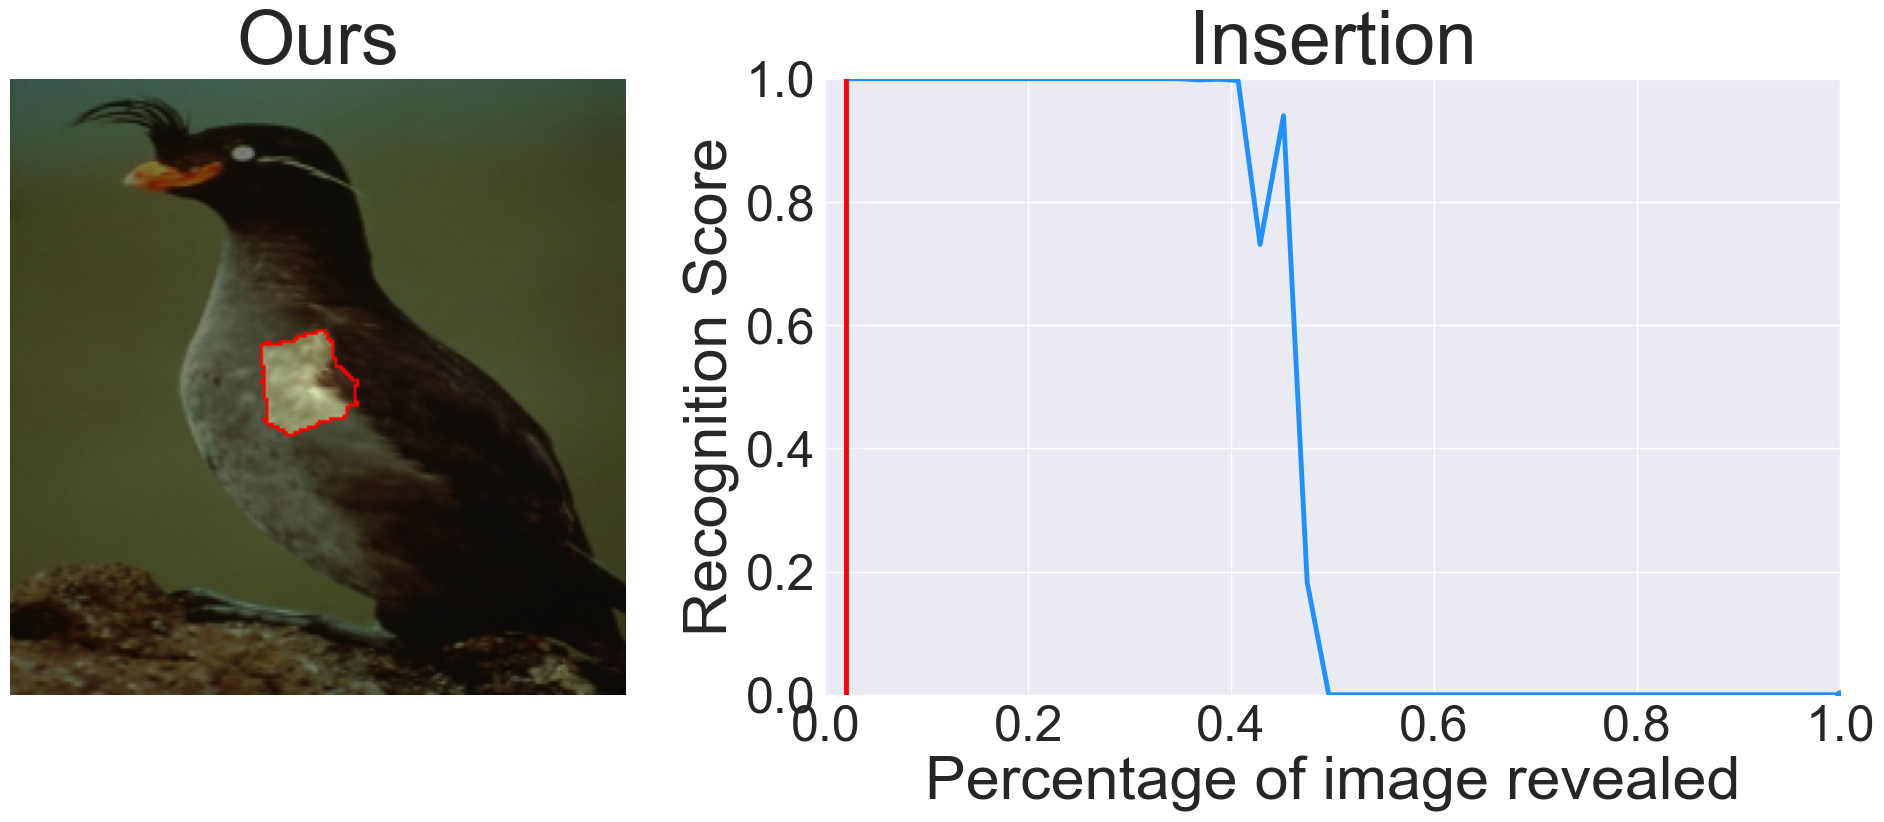

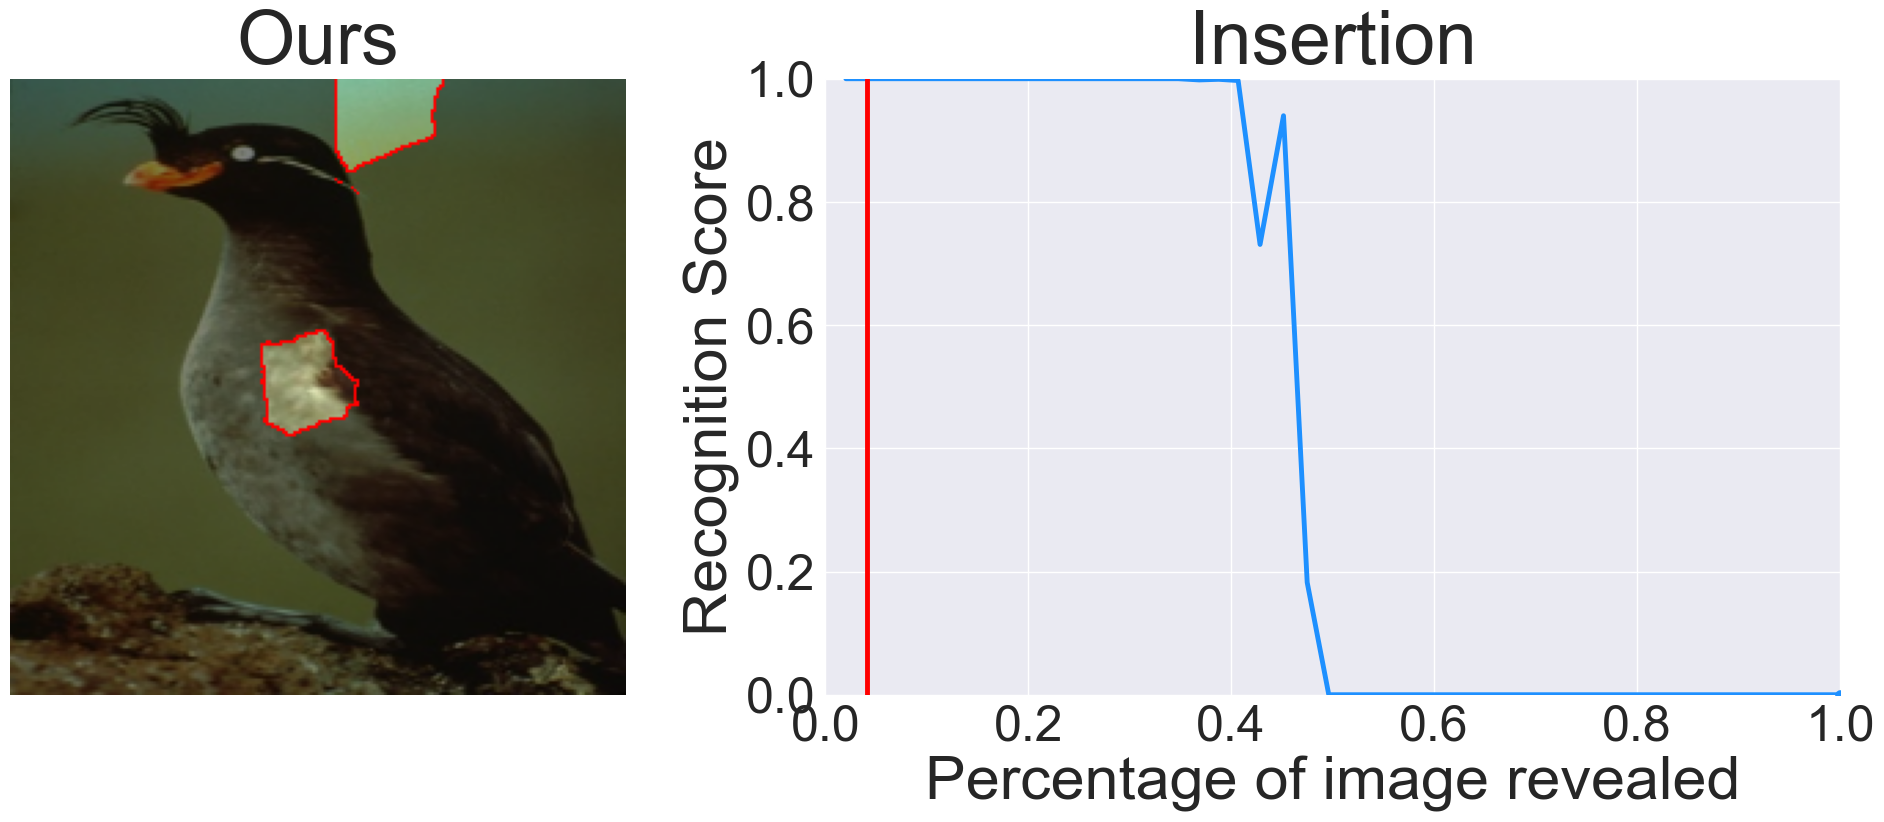

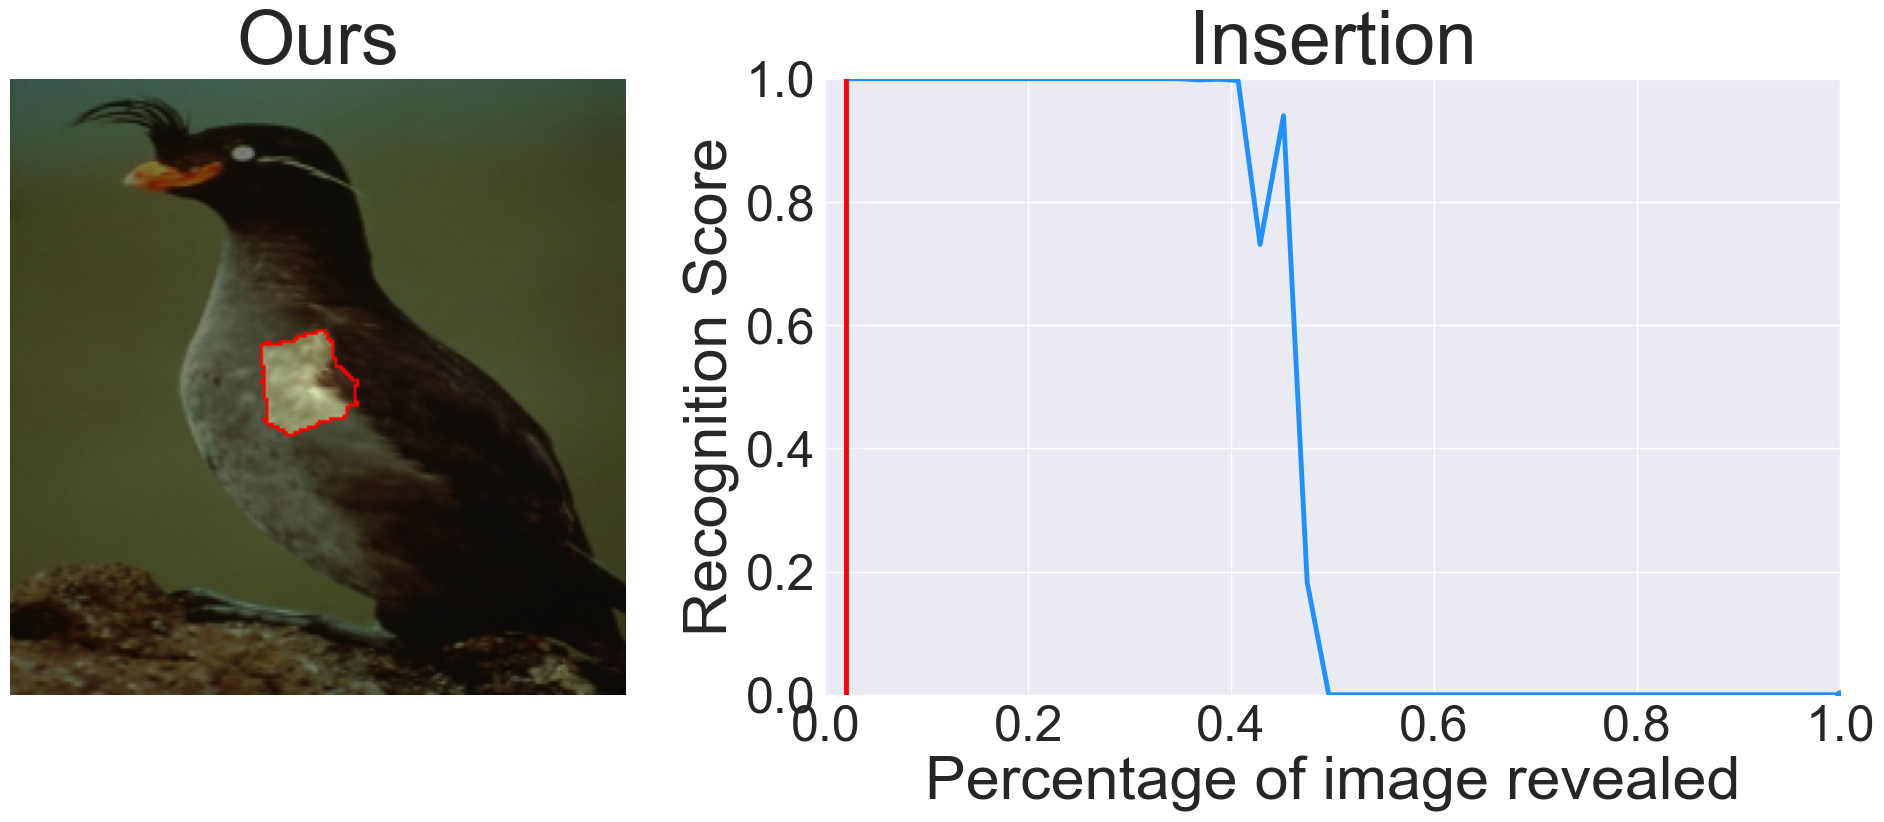

In [ ]:
# change index to visualize limited region
visualization(image, submodular_image_set, saved_json_file)

visualization(image, submodular_image_set, saved_json_file, index=5)

visualization(image, submodular_image_set, saved_json_file, index=10)